In [1]:
%matplotlib notebook

In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.mplot3d import Axes3D
import scipy.integrate as integrate
import glob

import scan
import load_scan
import cwesr_fit_single as cwfit
import current_profile as cp
import vector_reconstruction as vr
import current_reconstruction as cr

In [3]:
importlib.reload(load_scan);
importlib.reload(cwfit);
importlib.reload(cp);

In [4]:
PI = np.pi
scan2041path  = '/Users/alec/UCSB/scan_data/2041-esrdata/'
scan2028path = '/Users/alec/UCSB/scan_data/2028-esrdata/'
nvHeight = 40e-9
nvPhi = PI/4
nvTheta = 54.7*PI/180
tophBNThickness = 38
bottomhBNThickness = 95

<b>Highest sensitivity points should be at $f_0 \pm (A_{||}/2 + \sqrt{3}\Gamma/6$), where $f_0$ is the center frequency, $\Gamma$ is the ESR width, and $A_{||}$ is the higherfine splitting.</b> For $A_{||} = 3.1$ MHz, and the ESR above, the frequency modulation range should be:

<b>Frequency tracking</b>

In [5]:
scan2067 = load_scan.load_freq_track(2067,30);
scan2069 = load_scan.load_freq_track(2069,30);
scan2070 = load_scan.load_freq_track(2070,30);

<IPython.core.display.Javascript object>


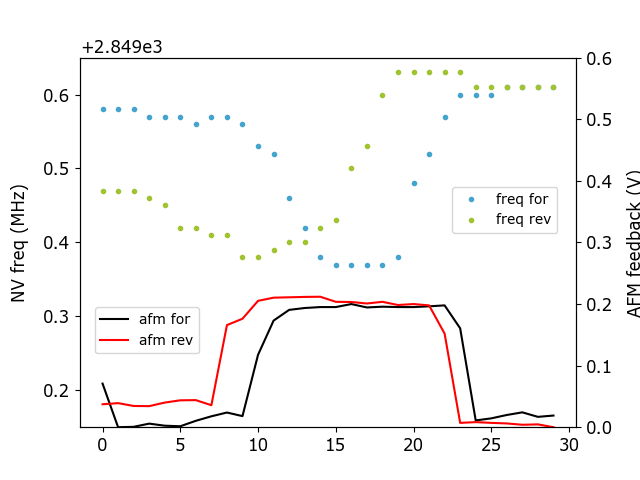

In [10]:
fig, ax = plt.subplots()
plt.plot(scan2067[2][0], '.', label='freq for')
plt.plot(scan2067[3][0], '.', label='freq rev')
ax.set_ylim([2.84915e3,2.84965e3])
ax.set_ylabel('NV freq (MHz)')
ax.legend(bbox_to_anchor=(0.75, 0.65), loc=2, borderaxespad=0., frameon=True, prop={'size':10})
ax_afm = ax.twinx()
plt.plot(np.max(scan2067[0][0])-scan2067[0][0], 'k', label='afm for')
plt.plot(np.max(scan2067[1][0])-scan2067[1][0], 'r', label='afm rev')
ax_afm.set_ylim([0.0,0.6])
ax_afm.set_ylabel('AFM feedback (V)')
ax_afm.legend(bbox_to_anchor=(0.03, 0.2), loc=3, borderaxespad=0., frameon=True, prop={'size':10});

<IPython.core.display.Javascript object>


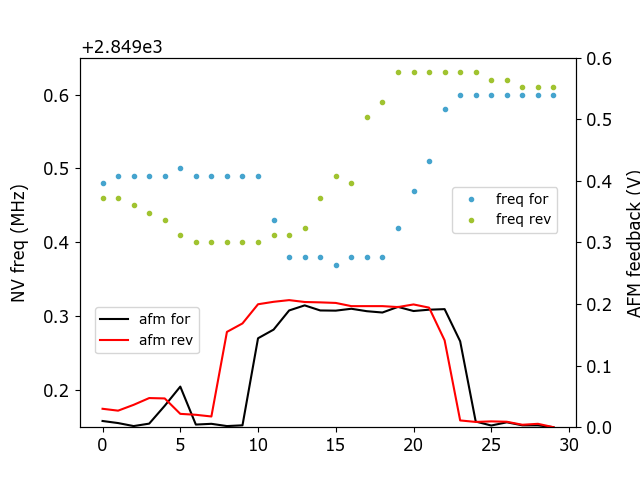

In [7]:
fig, ax = plt.subplots()
plt.plot(scan2067[2][1], '.', label='freq for')
plt.plot(scan2067[3][1], '.', label='freq rev')
ax.set_ylim([2.84915e3,2.84965e3])
ax.set_ylabel('NV freq (MHz)')
ax.legend(bbox_to_anchor=(0.75, 0.65), loc=2, borderaxespad=0., frameon=True, prop={'size':10})
ax_afm = ax.twinx()
plt.plot(np.max(scan2067[0][1])-scan2067[0][1], 'k', label='afm for')
plt.plot(np.max(scan2067[1][1])-scan2067[1][1], 'r', label='afm rev')
ax_afm.set_ylim([0.0,0.6])
ax_afm.set_ylabel('AFM feedback (V)')
ax_afm.legend(bbox_to_anchor=(0.03, 0.2), loc=3, borderaxespad=0., frameon=True, prop={'size':10});

<IPython.core.display.Javascript object>


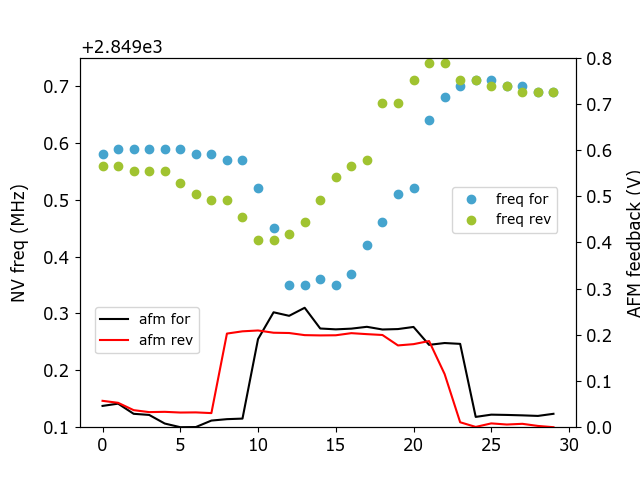

In [12]:
fig, ax = plt.subplots()
plt.plot(scan2070[2][0], 'o', label='freq for')
plt.plot(scan2070[3][0], 'o', label='freq rev')
ax.set_ylim([2.8491e3,2.84975e3])
ax.set_ylabel('NV freq (MHz)')
ax.legend(bbox_to_anchor=(0.75, 0.65), loc=2, borderaxespad=0., frameon=True, prop={'size':10})
ax_afm = ax.twinx()
plt.plot(np.max(scan2070[0][0])-scan2070[0][0], 'k', label='afm for')
plt.plot(np.max(scan2070[1][0])-scan2070[1][0], 'r', label='afm rev')
ax_afm.set_ylim([0.0,0.8])
ax_afm.set_ylabel('AFM feedback (V)')
ax_afm.legend(bbox_to_anchor=(0.03, 0.2), loc=3, borderaxespad=0., frameon=True, prop={'size':10});

<b>recontructing current density in channel from 1D linecut</b>:

$$ \tilde{B}_x (k_x, k_y=0, z) = \frac{\mu_0}{2} e^{-z \sqrt{k_x^2}} j_y(k_x, k_y=0) $$
$$ \tilde{B}_z(k_x, k_y=0, z) = -i \frac{\mu_0}{2} e^{-z \sqrt{k_x^2}} \frac{k_x}{\sqrt{k_x^2}}j_y(k_x,k_y=0)$$

roughly estimate NV orientation relative to channel with optical image, assume roughly parallel cantilever:

$$\theta_{NV} = 54.7^{\circ}$$
$$\phi_{NV} = 28^{\circ}$$

Fourier transforming the NV field $B_{NV}$, the cartesian components can be computed as (dropping y-dependence):

$$ \tilde{B}_x (k_x, z) = \frac{\tilde{B}_{NV}}{sin(\theta_{NV})cos(\phi_{NV})-i\frac{k_x}{|k_x|}cos(\theta_{NV})} $$

$$ \tilde{B}_z (k_x, z) = \frac{-i \frac{k_x}{|k_x|} \tilde{B}_{NV}}{sin(\theta_{NV})cos(\phi_{NV})-i\frac{k_x}{|k_x|}cos(\theta_{NV})} $$


Calculating the current density in terms of the NV field:

$$ \tilde{B}_{NV} = \tilde{B}_{x} sin(\theta_{NV}) cos(\phi_{NV}) + \tilde{B}_{z} cos(\theta_{NV}) $$

$$ \tilde{B}_{NV} = \frac{\mu_0}{2} e^{-z \sqrt{k_x^2}} \left(sin(\theta_{NV})cos(\phi_{NV}) - i \frac{k_x}{\sqrt{k_x^2}} cos(\theta_{NV})\right) \tilde{j}_y  $$

In [50]:
importlib.reload(vr);
importlib.reload(cr);

In [72]:
scan2070bnv = (scan2070[2][0]-np.mean(scan2070[2][0]))/(2.8e4)
bxdata, bzdata = vr.vector_reconstruction_1D(scan2070bnv, nvTheta, nvPhi)

In [73]:
jy, jyf = cr.current_reconstruction_1D(scan2070bnv, nvTheta, nvPhi, nvHeight, 2e-6)

<IPython.core.display.Javascript object>


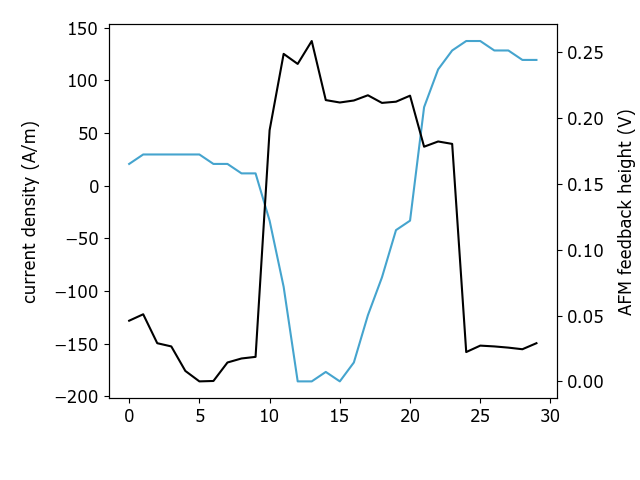

In [74]:
fig, ax = plt.subplots();
plt.plot(jy)
ax.set_ylabel('current density (A/m)')
ax_afm = ax.twinx()
plt.plot(np.max(scan2070[0][0])-scan2070[0][0], 'k')
ax_afm.set_ylabel('AFM feedback height (V)')
plt.subplots_adjust(left=0.17, bottom=0.17, right=0.87, top=0.95, wspace=0, hspace=0)

<IPython.core.display.Javascript object>


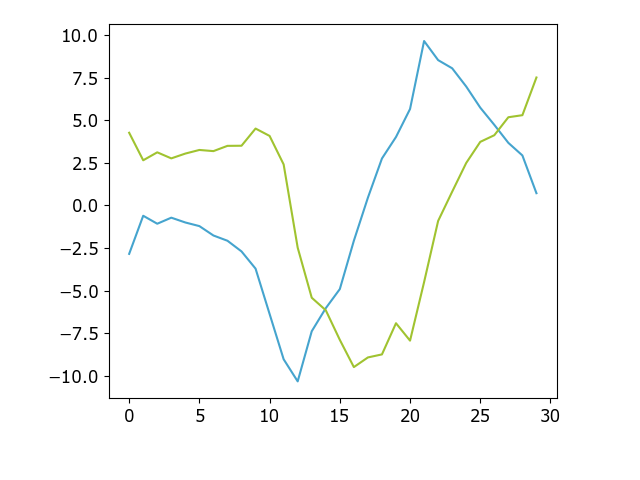

In [90]:
fig, ax = plt.subplots()
# ax.set_prop_cycle('color',plt.cm.spectral(np.linspace(0,1,10)))
plt.plot(bxdata*(1e6))
plt.plot(bzdata*(1e6))
plt.subplots_adjust(left=0.17, bottom=0.17, right=0.87, top=0.95, wspace=0, hspace=0)

In [91]:
print(plt.rcParams['axes.prop_cycle'].by_key()['color'])

['#45A4CE', '#A0C330', '#F9921B', '#F14F29', '#7EBC9B', '#A23E49', '#E58DB0', '#6B87C4', '#FFF275', '#BCAF5E']


<b> Current density reconstruction with varying NV height </b>

$$ B_x(x,y,z,z') = \frac{\mu_0}{4\pi} (z-z') \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} dx' dy' \frac{j_y(x',y',z')}{\left( (x-x')^2 + (y-y')^2 +(z-z')^2 \right)^{3/2}}  $$

$$ B_z(x,y,z,z') = \frac{\mu_0}{4\pi} \int_{-\infty}^{\infty} \int_{-\infty}^{\infty} dx' dy' \frac{-(x-x')~j_y(x',y',z')}{\left( (x-x')^2 + (y-y')^2 +(z-z')^2 \right)^{3/2}}  $$

For a channel with length greater than width $l >> w$, fields and current density $j_y$ are approximately uniform in y. $j_y(x',y',z') = j_y(x',0,z')$

$$ B_x(x,0,z,z') = \frac{\mu_0}{2\pi} (z-z') \int_{-\infty}^{\infty} dx' \frac{j_y(x',0,z')}{ (x-x')^2 +(z-z')^2 }  $$

$$ B_z(x,0,z,z') = \frac{\mu_0}{2\pi} \int_{-\infty}^{\infty} dx' \frac{-(x-x')~j_y(x',0,z')}{ (x-x')^2 +(z-z')^2}  $$

Let $f(x,z,z') = 1/(x^2+(z-z')^2)$, $g(x,z,z') = -x/(x^2+(z-z')^2)$.

$$ B_x = \frac{\mu_0}{2\pi} (z-z')~ [j_y * f] (x) $$

$$ \mathcal{F}[B_x] = \frac{\mu_0}{2\pi} (z-z')~ \mathcal{F}[j_y] \mathcal{F}[f]  $$

$$ \mathcal{F}[f] = \pi \frac{1}{|(z-z')|} e^{-|k_x(z-z')|} $$

$$ \tilde{B}_x(k_x,z,z') = \frac{\mu_0}{2} sgn(z-z') ~e^{-|k_x(z-z')|} \tilde{j}_y(k_x,z')  $$

$$ B_z = \frac{\mu_0}{2\pi} j_y * g (x) $$

$$ \mathcal{F}[B_z] = \frac{\mu_0}{2\pi} \mathcal{F}[j_y] \mathcal{F}[g]  $$

$$ \mathcal{F}[g] = -i \pi~ sgn(k_x)~ e^{-|k_x(z-z')|} $$

$$ \tilde{B}_z(k_x,z,z') = -i \frac{\mu_0}{2} sgn(k_x) ~e^{-|k_x(z-z')|} \tilde{j}_y(k_x,z')  $$

In [277]:
importlib.reload(scan);
scan2074 = scan.scan(2074, 50, 2)

<IPython.core.display.Javascript object>


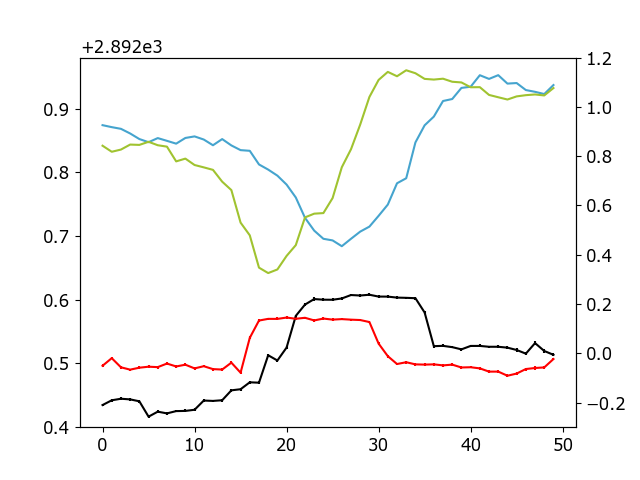

In [278]:
fig, ax = plt.subplots()
plt.plot(np.arange(len(scan2074.dataForward['freq'][0])), scan2074.dataForward['freq'][0])
plt.plot(np.arange(len(scan2074.dataReverse['freq'][0])), scan2074.dataReverse['freq'][0])
ax.set_ylim([2.8924e3,2.89298e3]);
ax_afm = ax.twinx()
plt.errorbar(np.arange(len(scan2074.dataForward['zPiezoVMean'][0])),
             np.mean(scan2074.dataForward['zPiezoVMean'][0])-scan2074.dataForward['zPiezoVMean'][0],
             yerr=scan2074.dataForward['zPiezoVStd'][0], color = 'k')
plt.errorbar(np.arange(len(scan2074.dataReverse['zPiezoVMean'][0])),
             np.mean(scan2074.dataReverse['zPiezoVMean'][0])-scan2074.dataReverse['zPiezoVMean'][0],
             yerr=scan2074.dataReverse['zPiezoVStd'][0], color = 'r')
ax_afm.set_ylim([-0.3,1.2]);

<IPython.core.display.Javascript object>


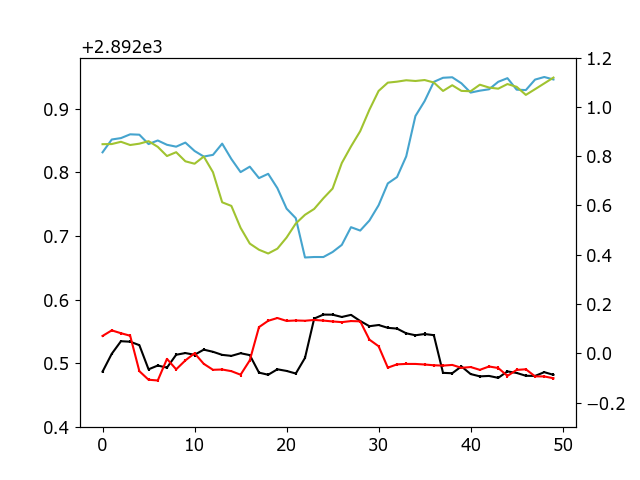

In [279]:
fig, ax = plt.subplots()
plt.plot(np.arange(len(scan2074.dataForward['freq'][1])), scan2074.dataForward['freq'][1])
plt.plot(np.arange(len(scan2074.dataReverse['freq'][1])), scan2074.dataReverse['freq'][1])
ax.set_ylim([2.8924e3,2.89298e3]);
ax_afm = ax.twinx()
plt.errorbar(np.arange(len(scan2074.dataForward['zPiezoVMean'][1])),
             np.mean(scan2074.dataForward['zPiezoVMean'][1])-scan2074.dataForward['zPiezoVMean'][1],
             yerr=scan2074.dataForward['zPiezoVStd'][1], color = 'k')
plt.errorbar(np.arange(len(scan2074.dataReverse['zPiezoVMean'][1])),
             np.mean(scan2074.dataReverse['zPiezoVMean'][1])-scan2074.dataReverse['zPiezoVMean'][1],
             yerr=scan2074.dataReverse['zPiezoVStd'][1], color = 'r')
ax_afm.set_ylim([-0.3,1.2]);